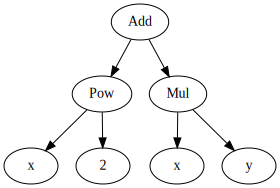

In [7]:
from sympy import *
import graphviz
x,y,z = symbols('x y z')
expr = x**2 + x*y
graphviz.Source(dotprint(expr))

# The simplest compilers
The simplicity frontier


Simple doesn't easily get you papers or acclaim

Or does it?

Pearls. 
Pedagogical undergrad material with get you 100x the name recognition your fanciest work will get you in many cases.


What the world needs is less mess.
Stripping of abstractions that don't help.
Avoiding useless work.


Backwards compilation
rubber stamp compilation

Can declarative compilers make life easier not harder?

https://github.com/rui314/chibicc
QBE

reg alloc gets you a lot of the way there and local value numbering
There is a difference between CPU compilation

https://www.reddit.com/r/Compilers/ pretty interesting stuff here actually

# Mini riscv



In [7]:
from collections import namedtuple

add = namedtuple('add', "rd rs1 rs2")
mov = namedtuple('mov', "rd rs1")
movi = namedtuple('movi', "rd imm")
sub = namedtuple('sub', "rd rs1 rs2")
mul = namedtuple('mul', "rd rs1 rs2")
div = namedtuple('div', "rd rs1 rs2")

def exec_insn(regs, insn):
    match insn:
        case add(rd, rs1, rs2):
            regs[rd] = regs[rs1] + regs[rs2]
        case sub(rd, rs1, rs2):
            regs[rd] = regs[rs1] - regs[rs2]
        case mul(rd, rs1, rs2):
            regs[rd] = regs[rs1] * regs[rs2]
        case div(rd, rs1, rs2):
            regs[rd] = regs[rs1] / regs[rs2]
        case mov(rd, rs1):
            regs[rd] = regs[rs1]
        case movi(rd, imm):
            regs[rd] = imm

def exec_insns(insns, regs=None):
    if regs is None:
        regs = [0]*32
    for insn in insns:
        exec_insn(regs, insn)
    return regs

for n in range(32):
    exec(f"r{n} = n")
ra = r1
sp = r2
gp = r3


prog = [
    movi(r2, 2),
    movi(r3, 1),
    add(r1,r2,r3)
]
exec_insns(prog)


prog = [
    label0 := [

    ],
    label1 := [

    ]
    label3 := [
        
    ]
]

[0,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
def add(x,y):
    z = st.alloc()
    st.emit(add(z,x,y))
    return z




## Kroening talk

annapurna labs - silicon innovatio at aws

aws nitro  - hypervisor sotrage ssd security
aws graviton3 - power and effcient moden applications
aws inferentia and trainium - mochine learning accerelation


rufus chatpot

machine learnin trends - 

ai accelerator. application sepcific hardware


- load data from model - compute - stroe result in memory
- set of workloads is not turing complete
- embrassigly parralle and structure. matrix multiplciation

- workload is known ahead of tme
    +  no need for out-of-order execution
    +  can use software managed scrtachpad instead of cache


trainum. intferentia2 is trainium

Trinium accelerator. power delviry

60% faster. neroncore x8

10.4pflops
51.2 tb/sec 
1536gb
6400 gbps

HBM. same as nvidia

aws and claude. anthorpic. Amazon pays anthropc

apple in vega on monday

pytorch and jax


cpu optimization compielr aren't that great. 5%
ai accelerators 

accelerators are a software problem


trainium
NeuronCore
- systolic
- on chip scratchpad
- vector/scalar
https://en.wikipedia.org/wiki/High_Bandwidth_Memory

vector engine
pe-array
why sstolic arrray KT Kung
PE - prcoessing eleemenmt

fused multiply add
google tpu style arctecture
systolic array for matmult
systolic array for fft

99.99% is matrix multiplication
optimize for matmul

energy. data movement is expensive. 
DRAM read most power by a lot, float multiply.
Loads and store from dram is extremely costly


streaming driection
accumulation direction

data goes in diagonally
wavefrontd

0 shuts down local pe to save electricity

tasnium1 
128x128*2 = 32000 flops
3.1ghz
32 pe per trainum1

32 bit floating point
fp8 supported in hardware. reduces memory bandwidth. compute is irrelvant. They pad out to make them fp32 for the systolic array


isa format - 2-300 instructions.

trainium3. bottleneck is wirgrng to hbm
16000x


on chip scrthpad. no a cache. sram near compute. softeare managed not hardware managed.
similar to trasnputre. Cell BE. Cell BE hard to prgram. instructiond are very similar.
interleave dma and compute
128 partitions like google tpu.  each part connected to part of systolic array
allowd


memory hierarchy
PSUM
SBUF
Device Memory HBM
DRAM

PSUM and sbuf inside neroncore


nuuron compilter
trainsium ISA.


computation graph
frameworkx
graph optimization  => loop nests

memory copt elimination
layout optimization
tiling
hardware primitive mapping
roofline based matmul fusion

allocation and schuedling 

systolic based accel


NP-ard problems in compuler

partition dim selection
dimension ordering
sharding

NKI neuron kernel interface NKI
python  embedding. syntax for assembler language. Just syntax really. Not even a library?

There are docs for it

schuduling to 16000 racks





side comment: use PE array to do tranpose. dma can do tranpose. others do hadrwae tranpose.










Thoguhts on tslk structure - yes, my graphics stink. joke about domes. not bad.




In [27]:
print(dotprint(expr))

digraph{

# Graph style
"ordering"="out"
"rankdir"="TD"

#########
# Nodes #
#########

"Add(Pow(Symbol('x'), Integer(2)), Mul(Symbol('x'), Symbol('y')))_()" ["color"="black", "label"="Add", "shape"="ellipse"];
"Pow(Symbol('x'), Integer(2))_(0,)" ["color"="black", "label"="Pow", "shape"="ellipse"];
"Symbol('x')_(0, 0)" ["color"="black", "label"="x", "shape"="ellipse"];
"Integer(2)_(0, 1)" ["color"="black", "label"="2", "shape"="ellipse"];
"Mul(Symbol('x'), Symbol('y'))_(1,)" ["color"="black", "label"="Mul", "shape"="ellipse"];
"Symbol('x')_(1, 0)" ["color"="black", "label"="x", "shape"="ellipse"];
"Symbol('y')_(1, 1)" ["color"="black", "label"="y", "shape"="ellipse"];

#########
# Edges #
#########

"Add(Pow(Symbol('x'), Integer(2)), Mul(Symbol('x'), Symbol('y')))_()" -> "Pow(Symbol('x'), Integer(2))_(0,)";
"Add(Pow(Symbol('x'), Integer(2)), Mul(Symbol('x'), Symbol('y')))_()" -> "Mul(Symbol('x'), Symbol('y'))_(1,)";
"Pow(Symbol('x'), Integer(2))_(0,)" -> "Symbol('x')_(0, 0)";
"Pow(Symb

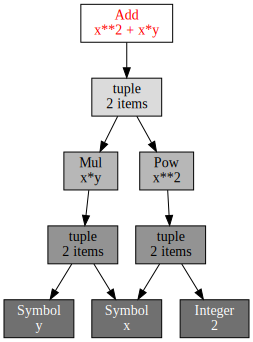

In [24]:
import objgraph

def show_dag(expr):
    return objgraph.show_refs([expr], 
                    max_depth=5,
                    filter=lambda x: isinstance(x,Basic) or isinstance(x,tuple) or isinstance(x, Mul) or isinstance(x,Symbol)
                    )

show_dag(expr)

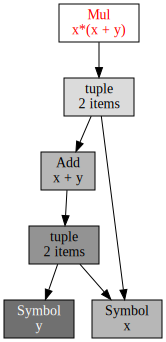

In [25]:
show_dag(expr.simplify())

In [21]:
type((x*y).args[0])

sympy.core.symbol.Symbol

+(*(c, +(b, *(a, 0))), 7)


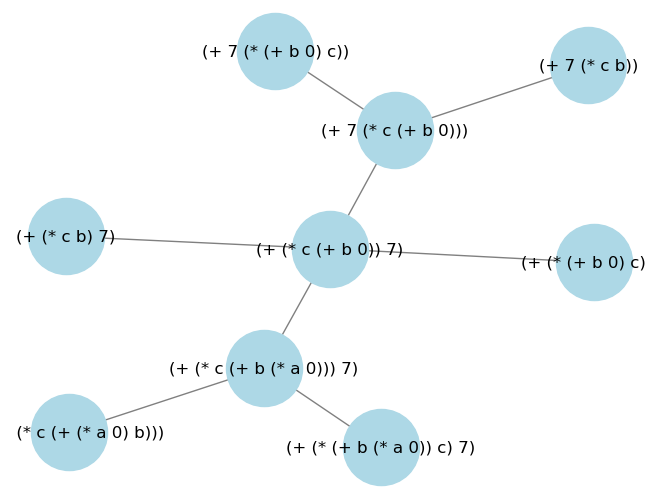

In [92]:
from sympy import symbols, Wild, simplify, Add, Mul, Basic
import networkx as nx
import matplotlib.pyplot as plt

# Define symbols
a, b, c, x = symbols('a b c x')

# Wildcards for pattern matching
w1 = Wild('w1')
w2 = Wild('w2')

mul = Function("*")
add = Function("+")

# Define initial expression
import functools
#expr = functools.reduce(add, [mul(c, add(b,mul(a, 0))), 7, -mul(c, b), 6, x])

expr = functools.reduce(add, [mul(c, add(b,mul(a, 0))), 7])


# Rewriting rules as (pattern, replacement)
rules = [
    (mul(0, w1), 0), 
    (mul(w1, 0), 0),                  # Simplify multiplication by 0
    (add(w1, 0), w1),                 # Remove addition with 0
    (add(w1,w2), add(w2,w1)),         # Simplify addition
    (mul(w1, w2), mul(w2, w1)),       # Simplify multiplication
    #(Add(w1, w2), w1 + w2), # Simplify addition
]
print(expr)

def to_sexpr(expr):
    if isinstance(expr, Basic):
        if expr.args:  # If the expression has arguments, process them recursively
            return f"({expr.func.__name__} " + " ".join(to_sexpr(arg) for arg in expr.args) + ")"
        else:  # Leaf node
            return str(expr)
    else:  # For non-SymPy objects, return their string representation
        return str(expr)

todo = set([expr])
done = set()
edges = set()
G = nx.Graph()
evaluate(False)
while todo and len(done) < 3:
    expr = todo.pop()
    done.add(expr)
    for lhs,rhs in rules:
        e1 = expr.replace(lhs,rhs)
        #e2 = expr.replace(rhs,lhs)
        if e1 not in done:
            #G.add_edge(expr.replace(mul(w1,w2), Mul(w1,w2)),e1.replace(mul(w1,w2), Mul(w1,w2)))
            G.add_edge(to_sexpr(expr),to_sexpr(e1))
            todo.add(e1)
        #if e2 not in done:
        #    todo.add(e2)
        #print(expr.match(lhs))
        #print(expr.replace(lhs,rhs, map=True))
rules
done
edges
pos = nx.spring_layout(G) 
nx.draw(G,pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="gray")


In [ ]:

# Function to apply rules and populate the graph
def apply_rewrites(expr, rules, graph):
    nodes_to_visit = [expr]
    visited = set()

    while nodes_to_visit:
        current = nodes_to_visit.pop()
        if current in visited:
            continue
        visited.add(current)

        for pattern, replacement in rules:
            if current.has(pattern):
                # Rewrite the expression
                rewritten = current.replace(pattern, replacement)
                if rewritten != current:  # If the rule changed the expression
                    graph.add_node(str(rewritten))
                    graph.add_edge(str(current), str(rewritten), label=str(pattern) + " -> " + str(replacement))
                    nodes_to_visit.append(rewritten)

apply_rewrites(expr, rules, G)

# Graph to store rewriting process
G = nx.DiGraph()
G.add_node(str(expr))


https://github.com/mwillsey/cs265/blob/2024-fall/reading/ir-survey.md  ntermediate Representations in Imperative Compilers: A Survey

https://dl.acm.org/doi/10.1145/197405.197406 Compiler transformations for high-performance computing

Outline
Reuse frontend of my talk
Reuse stuff from aegraph talk




clif https://github.com/bytecodealliance/wasmtime/blob/main/cranelift/docs/ir.md
https://hacks.mozilla.org/2020/10/a-new-backend-for-cranelift-part-1-instruction-selection/
https://cfallin.org/blog/2020/09/18/cranelift-isel-1/
wasm



# Seqeunce Egraphs and peephole optimizations
https://toot.cat/@jamey/113432501610320973

side-effecting skeleton.

We can use a half sequenced IR. Anything dataflowy can be pushed in

computation can be swapped through side effecting stuff.
(mov r0 r1)(store r0) == store(r1)mov(r0,r1)
add(r0,r1)(store r0) -> store(r0 + r1)add(r0,r1) # hmm. requires substitution.
add(r0,r1)(store e) -> store(e[r0+r1 / r0])add(r0,r1)

compuitation into non live memory can get absorbed. Block ends  are marked by liveness.
mov(r7,r4)branch([r0,r1,r2]) ->  branch([r0,r1,r2])



Show images of how egraph does not share much in the presence of lists or seqeunces.


This is an egraph style *spl*

You want to permute loads to come as far before things that use them

Permutation of instructions and memory models. fences allow some things to pass over. One way commutativity. This is refinement egraph not equational?


stack machine style

https://blog.regehr.org/archives/2485  Why Do Peephole Optimizations Work?
"SSA extracts out a functional sub language" That's an interesting way of putting it

https://dl.acm.org/doi/10.1145/364995.365000 Peephole optimization 1965
https://dl.acm.org/doi/10.1145/3649837  Hydra: Generalizing Peephole Optimizations with Program Synthesis

CF has some peepholes
https://pypy.org/posts/2024/10/jit-peephole-dsl.html

https://www.reddit.com/r/Forth/comments/lxtyfm/optimizing_large_forth_program/

forth subroutine inlining - this does kind of need... no. That works

(define (forthsub tl) (body body body tl)) # works

(rewrite (saxpy tl) ((mul (add tl))))

some light dup swapping





In [40]:
from collections import namedtuple
add = "add"
sub = "sub"
mul = "mul"
div = "div"
shl = "shl"
pop = "pop"
push = namedtuple('push', ['a'])



def interp(prog):
    stack = []
    for cmd in prog:
        match cmd:
            case push(a):
                stack.append(a)
            case "add":
                stack.append(stack.pop()+stack.pop())
            case "sub":
                stack.append(stack.pop()-stack.pop())
            case "mul":
                stack.append(stack.pop()*stack.pop())
            case "div":
                stack.append(stack.pop()/stack.pop())
            case "shl":
                stack.append(stack.pop()<<stack.pop())
            case pop:
                stack.pop()
    return stack[-1]

prog = (push(1),push(2),add) 
print(interp(prog)) # 3

rw = namedtuple('rw', ['lhs', 'rhs'])

rules = [
    rw((push(1), pop) , ()),
    rw((push(1), push(2), add) , (push(3),)),
    rw((push(1), push(2), sub) , (push(-1),)),
]
assert skb.rewrite(prog, rules) == (push(3),)

add = namedtuple("add", [])
sub = namedtuple("sub", [])
add() < sub()
sub() < add()
sub() == add() # True. Hmm.
add = lambda x,y: ("add",)
# use tagged form so they are compared on tag first.
# push x, push y,  add = push y, push x, add
# use div2 -> shl example

def find_eqs(s):
    res = []
    for i in range(len(s)):
        t = s[i,i+2]
        # in rust these would be if let.
        match t:
            case (push(a), push(b), add):
                res.append(rw(t, (push(b), push(a), add)))
        match t:
            case (push(a), push(b), add): # constant folding
                res.append(rw(t, (push(a + b))))
        match t:
            case (push(a), pop()): # redudnant push pop
                res.append(rw(t, ()))
        match t:
            case (push(a), push(0), add):
                res.append(rw(t, push(a)))
        match t:
            case (nop()):
                res.append(rw(t, ()))
        match t:
            case (neg, neg):
                res.append(rw(t, ()))
        match t:
            case (push(n), mul) if log2(n) == 0: 
                res.append(rw(t, (push(n // 2), shl)))
        match t:
            case ()
        match t:
            case (push(x), mul, push(x1), div) if x == x1: 
                res.append(rw(t,

SyntaxError: expected ':' (1264552870.py, line 81)

In [66]:
%%file /tmp/stack.egg
(datatype SP 
    (push i64 SP)
    (pop SP)
    (add SP)
    (sub SP)
    (mul SP)
    (div SP)
    (shl SP)
    (Nil)
) ; stack prog

(rewrite (push n (pop tl)) tl)
(rewrite (push n (push m (add tl))) (push (+ n m) tl))
(rewrite (push n (push m (add tl))) (push m (push n (add tl))))

(let t (push 1 (push 2 (add (pop (Nil))))))
; really it'd be better to define in reverse order
(run 10)
(extract t)


Overwriting /tmp/stack.egg


In [65]:
! egglog /tmp/stack.egg

275833.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[ERROR] In 16:1-1 of /tmp/stack.egg: (
    expected ")"


In [59]:
%%file /tmp/perm.egg
(datatype List (Cons i64 List) (Nil))

(let t (Cons 1 (Cons 2 (Cons 3 (Cons 5 (Cons 4 (Cons 6 (Cons 7 (Cons 8 (Nil))))))))))
(rewrite (Cons x (Cons y tl)) (Cons y (Cons x tl)))
(run 1)
(extract t)
(print-size Cons)

Overwriting /tmp/perm.egg


In [60]:
! egglog /tmp/perm.egg

275710.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[INFO ] Declared sort List.
[INFO ] Declared function Cons.
[INFO ] Declared function Nil.
[INFO ] Declared function t.
[INFO ] Declared rule (rewrite (Cons x (Cons y tl)) (Cons y (Cons x tl))).
[INFO ] Ran schedule (repeat 1 (run)).
[INFO ] Report: Rule (rule ((= rewrite_var__ (Cons x (Cons y tl))))       ((union rewrite_var__ (Cons...: search 0.000s, apply 0.000s, num matches 7
    Ruleset : search 0.000s, apply 0.000s, rebuild 0.000s
    
[INFO ] extracted with cost 17: (Cons 1 (Cons 2 (Cons 3 (Cons 5 (Cons 4 (Cons 6 (Cons 7 (Cons 8 (Nil)))))))))
[INFO ] Function Cons has size 22
(Cons 1 (Cons 2 (Cons 3 (Cons 5 (Cons 4 (Cons 6 (Cons 7 (Cons 8 (Nil)))))))))
22


Wow. Surprisingly fast. 2^8 = 1024.

register machine style

In [ ]:
%%file /tmp/reg.egg

(datatype Reg
    (R0) (R1) (R2) (R3) (R4) (R5) (R6) (R7) (R8) (R9) (R10) (R11) (R12))
(datatype Insns
    (add Reg Reg Insns)
    (sub Reg Reg Insns)
    (mul Reg Reg Insns)
    (End)
)
;(dataype Insn (I op Reg Reg)) ; This generic form let's us write inference without speiclaizing to each instruction.
;(dataype Prog (N Insn Prog) (Done))
(relation live Insns Reg)
(live (End) (R0))
(rule ((= i (add a b nxt)) (live nxt c) (c != a)) 
      ((live i c)))
(let prog (add (R0) (R1) (add (R1) (R2) (End))))
(run 1000)

; contextual rewriting depending on what is live in to be used.

(rewrite (add a b (add c d tl)) (add c d (add a b tl))
:when ((!= a c) (!= a d) (!= b c) (!= b d)))
)






In [22]:
import eggmt.string_kb as skb
from namedtuple import namedtuple
add = namedtuple('add', ['a', 'b'])
sub = namedtuple('sub', ['a', 'b'])
mul = namedtuple('mul', ['a', 'b'])
shift = namedtuple('shift', ['a', 'b'])
push = namedtuple('push', ['a'])
pop = namedtuple('pop', ['out'])
x,y,z,w = "x y z w".split()

tuple(add(x,y), sub(x,y), mul(x,y), div(x,y), mod(x,y), shift(x,y), push(x), pop(x))






skb.KB


# Minijit
https://github.com/cslarsen/minijit
https://github.com/zserge/tinylangs/blob/main/asm.py
https://github.com/benhoyt/pyast64  https://benhoyt.com/writings/pyast64/
https://github.com/Maratyszcza/PeachPy
https://github.com/ssloy/tinycompiler

https://news.ycombinator.com/item?id=14644576

https://gitlab.com/tsoding/porth https://www.youtube.com/watch?v=QlKSCn-Al6Q&ab_channel=TsodingDaily

In [15]:
def saxpy():
    x = 3
    y = 4
    return x*y + y

import dis
dis.dis(saxpy)
code = saxpy.__code__
code.co_consts
bytecode = list(code.co_code)
dis.opname[bytecode[0]]
dis.opname[bytecode[2]]
list(dis.get_instructions(saxpy))
dis.show_code(saxpy)
dis.code_info(saxpy)

  2           0 LOAD_CONST               1 (3)
              2 STORE_FAST               0 (x)

  3           4 LOAD_CONST               2 (4)
              6 STORE_FAST               1 (y)

  4           8 LOAD_FAST                0 (x)
             10 LOAD_FAST                1 (y)
             12 BINARY_MULTIPLY
             14 LOAD_FAST                1 (y)
             16 BINARY_ADD
             18 RETURN_VALUE
Name:              saxpy
Filename:          /tmp/ipykernel_619076/1383081438.py
Argument count:    0
Positional-only arguments: 0
Kw-only arguments: 0
Number of locals:  2
Stack size:        2
Flags:             OPTIMIZED, NEWLOCALS, NOFREE
Constants:
   0: None
   1: 3
   2: 4
Variable names:
   0: x
   1: y


'Name:              saxpy\nFilename:          /tmp/ipykernel_619076/1383081438.py\nArgument count:    0\nPositional-only arguments: 0\nKw-only arguments: 0\nNumber of locals:  2\nStack size:        2\nFlags:             OPTIMIZED, NEWLOCALS, NOFREE\nConstants:\n   0: None\n   1: 3\n   2: 4\nVariable names:\n   0: x\n   1: y'

In [21]:
def interp(f):
    code = f.__code__
    stack = []
    insns = list(dis.get_instructions(code))
    store = [0] * len(code.co_varnames)
    pc = 0
    while True:
        insn = insns[pc]
        print(insn.opname, insn.argval)

        match insn.opname:
            case 'LOAD_CONST':
                stack.append(code.co_consts[insn.arg])
                pc += 1
            case 'LOAD_FAST':
                stack.append(store[insn.arg])
                pc += 1
            case 'STORE_FAST':
                store[insn.arg] = stack.pop()
                pc += 1
            case 'BINARY_MULTIPLY':
                stack.append(stack.pop() * stack.pop())
                pc += 1
            case 'BINARY_ADD':
                stack.append(stack.pop() + stack.pop())
                pc += 1
            case 'RETURN_VALUE':
                return stack.pop()
interp(saxpy)

LOAD_CONST 3
STORE_FAST x
LOAD_CONST 4
STORE_FAST y
LOAD_FAST x
LOAD_FAST y
BINARY_MULTIPLY None
LOAD_FAST y
BINARY_ADD None
RETURN_VALUE None


16

In [19]:
for insn in dis.get_instructions(saxpy):
    print(insn.opname, insn.argval)
    match insn.opname:
        case 'LOAD_CONST':
            print('const:', code.co_consts[insn.arg])
        case 'LOAD_FAST':
            print('local:', code.co_varnames[insn.arg])
        case 'BINARY_MULTIPLY':
            print('multiply')
        case 'BINARY_ADD':
            print('add')




LOAD_CONST 3
const: 3
STORE_FAST x
LOAD_CONST 4
const: 4
STORE_FAST y
LOAD_FAST x
local: x
LOAD_FAST y
local: y
BINARY_MULTIPLY None
multiply
LOAD_FAST y
local: y
BINARY_ADD None
add
RETURN_VALUE None


# Toy Optimzier
https://pypy.org/posts/2022/07/toy-optimizer.html toy optimzier
https://pypy.org/posts/2024/08/toy-knownbits.html
https://gist.github.com/tekknolagi/4425b28d5267e7bae8b0d7ef8fb4a671

Avoiding variables is a nice simplification

In [33]:
from dataclasses import dataclass, field
#class Value():
#    pass
#@dataclass
#class Const(Value):
#    value: int

@dataclass
class Op():
    op: str
    args: list[object]
    # sort: Optional[str] = None
    def __repr__(self):
        return f'{self.op} {self.args}'

@dataclass
class Block():
    insns : list[Op] = field(default_factory=list)
    def build(self, name, *args):
        o = Op(name, args)
        self.insns.append(o)
        return o # return len(self.insns)-1
    const = lambda self, args: self.build('const', args)
    add = lambda self,x,y: self.build('add', x,y)
    sub = lambda self,x,y: self.build('sub', x,y)
    mul = lambda self,x,y: self.build('mul', x,y)
    lshift = lambda self,x,y: self.build('lshift', x,y)


bb = Block()
[x := bb.const(1), 
 y := bb.const(2), 
 z := bb.add(x,y)
]


[const (1,), const (2,), add (const (1,), const (2,))]

In [ ]:
# hashing
@dataclass
class Block():
    insns : list[Op] = field(default_factory=list)
    hashcons = {}
    # functools.cache ?
    def build(self, name, *args):
        o = Op(name, args)
        if o in self.hashcons:
            return self.hashcons[o]
        else:
            self.insns.append(o)
            self.hashcons[o] = i
            return o

In [ ]:
@dataclass
class Block():
    insns : list[Op] = field(default_factory=list)
    uf : list[int] = field(default_factory=list)
    def build(self, name, *args):
        o = Op(name, args)
        self.insn.add(o)
        self.uf.append(len(self.uf)-1)
    def find(self, x):
        while self.uf[x] != x:
            x = self.uf[x]
        return x
    def union(self, x, y):
        x = self.find(x)
        y = self.find(y)
        self.uf[x] = y
    
# but what's the point? Who would call union?
# maybe some kind of dataflow analysis?



# Appell Tail Call

In [ ]:
# block with arguments. This is a first order function then

class Block():
    def __init__(self, name, *args):
        self.name = name
        self.args = args
        self.insns = []
    def __getitem__(self, args):
        return [op.substitute(self.args, args) for op in self.insns]
    def __call__(self, *args):
        return Op("call", self, args)
    def to_z3(self):
        for i in insn:
            pass





In [ ]:
# unison style maximal ssa block
class Block():
    def __init__(self, name, ins, outs):
        self.name = name
        self.ins = ins
        self.outs = outs
        self.insns = []

In [ ]:
# universal function graph blindell


# RVSDG

Kind of this one is a tree decomposition / hiearchical view of the graph.
https://langdev.stackexchange.com/questions/1823/what-is-the-relationship-between-stg-and-rvsdg
https://langdev.stackexchange.com/questions/2897/what-are-the-tradeoffs-between-using-sea-of-nodes-cfg-of-basic-blocks-and-egra?rq=1

https://github.com/SeaOfNodes/Simple

In [ ]:
class Region():
    ins:
    outs:
    subregions: Region

In [ ]:
# regions / hierarchy
# rvsdg or 

Yes, if you want to call Op an enode. and uf.
It's the same thing



# Sea of nodes
https://www.oracle.com/technetwork/java/javase/tech/c2-ir95-150110.pdf
https://github.com/SeaOfNodes

In [ ]:
class Control():
    pass
class Data():
    pass

class Region(Control):
    control : list[Region]

class Op():
    region: Optional[Region]
    op : str
    args : list[object]

# phi fits as an Op
#class Phi():
#    region: Optional[Region] # control?
#    args : list[object]

class If(Control):
    control : Control
    predicate : Op 
    truth : bool # could put truth assumption here.

# Class IfTrue():
#  ifnode : If

# another approach. Nodes that have multi output output tuples instead which need to be projected to be used.
class Project():
    node : Op
    index : int

# Store 
#class Store()

Could I throw an Eclass node indirection in there? Maybe.




# IR
- Use no IR do by hand
- bril
- llvm
- mlir
- ?

# Bril

bril programs.
to_ssa
from_ssa
df dataflow

I could copy these over

In [10]:
sorted(bril.bril_dict.keys())

['ackermann',
 'adj2csr',
 'adler32',
 'armstrong',
 'binary-fmt',
 'binary-search',
 'birthday',
 'bitshift',
 'bitwise-ops',
 'bubblesort',
 'catalan',
 'check-primes',
 'cholesky',
 'collatz',
 'conjugate-gradient',
 'cordic',
 'csrmv',
 'dead-branch',
 'digital-root',
 'dot-product',
 'eight-queens',
 'euclid',
 'euler',
 'fact',
 'factors',
 'fib',
 'fitsinside',
 'fizz-buzz',
 'function_call',
 'gcd',
 'hanoi',
 'is-decreasing',
 'lcm',
 'leibniz',
 'loopfact',
 'major-elm',
 'mandelbrot',
 'mat-inv',
 'mat-mul',
 'max-subarray',
 'mod_inv',
 'n_root',
 'newton',
 'norm',
 'orders',
 'palindrome',
 'pascals-row',
 'perfect',
 'pow',
 'primes-between',
 'primitive-root',
 'pythagorean_triple',
 'quadratic',
 'quickselect',
 'quicksort',
 'quicksort-hoare',
 'ray-sphere-intersection',
 'recfact',
 'rectangles-area-difference',
 'relative-primes',
 'reverse',
 'riemann',
 'sieve',
 'sqrt',
 'sum-bits',
 'sum-check',
 'sum-divisors',
 'sum-sq-diff',
 'totient',
 'two-sum',
 'up-arrow

In [11]:
import bril
fact = bril.bril_dict["loopfact"]
#print(fact)
fact = bril.parse_bril(fact)
bril.print_prog(bril.to_ssa(fact))

@main(input: int) {
.b1:
  value.0: int = id input;
  v1.0: int = const 1;
  result.0: int = id v1.0;
  v3.0: int = id value.0;
  i.0: int = id v3.0;
  jmp .for.cond.2;
.for.cond.2:
  v9.0: int = phi __undefined v9.1 .b1 .for.body.2;
  v8.0: int = phi __undefined v8.1 .b1 .for.body.2;
  v7.0: int = phi __undefined v7.1 .b1 .for.body.2;
  v6.0: bool = phi __undefined v6.1 .b1 .for.body.2;
  v5.0: int = phi __undefined v5.1 .b1 .for.body.2;
  v4.0: int = phi __undefined v4.1 .b1 .for.body.2;
  v12.0: int = phi __undefined v12.1 .b1 .for.body.2;
  v11.0: int = phi __undefined v11.1 .b1 .for.body.2;
  v10.0: int = phi __undefined v10.1 .b1 .for.body.2;
  result.1: int = phi result.0 result.2 .b1 .for.body.2;
  i.1: int = phi i.0 i.2 .b1 .for.body.2;
  v4.1: int = id i.1;
  v5.1: int = const 0;
  v6.1: bool = gt v4.1 v5.1;
  br v6.1 .for.body.2 .for.end.2;
.for.body.2:
  v7.1: int = id result.1;
  v8.1: int = id i.1;
  v9.1: int = mul v7.1 v8.1;
  result.2: int = id v9.1;
  v10.1: int = id 

In [13]:
list(bril.form_blocks(fact["functions"][1]["instrs"]))


def exec_op(op, state):
    match op["op"]:
        case "const":
            return z3.IntVal(op["value"])
        case "id":
            return state[op["args"][0]]
        case "add":
            return state[op["args"][0]] + state[op["args"][1]]
        case "mul":
        case "sub":
    state[op["dest"]] = res
    return state

state = defaultdict(lambda: z3.Int("undef"))

def symexec(block):
    assert block[0].op == "label"
    for insn in block[1:]:






IndexError: list index out of range

In [ ]:
def const(x):
    return {"op": "const", "value": x}
def add(x,y):
    return {"op": "add", "args": [x,y]}
def sub(x,y):
    return {"op": "sub", "args": [x,y]}
def mul(x,y):
    return {"op": "mul", "args": [x,y]}
def id(x):
    return {"op": "id", "args": [x]}
def jmp(lbl):
    return {"op": "jmp", "args": [lbl]}
def call(fn, *args):
    return {"op": "call", "args": [fn] + list(args)}

def add(dst,x,y):
    return {"op": "add", "dest": dst, "args": [x,y]}
def eq(dst,x,y):
    return {"op": "eq", "dest": dst, "args": [x,y]}
def lt(dst,x,y):
    return {"op": "lt", "dest": dst, "args": [x,y]}
def jmp(lbl):
[
    y := const(0),

]

In [12]:
bril.to_ssa(fact)

{'functions': [{'args': [{'name': 'a', 'type': 'int'}],
   'instrs': [{'label': 'b1'},
    {'args': ['a'],
     'dest': 'x.0.0',
     'funcs': ['fact'],
     'op': 'call',
     'type': 'int'},
    {'args': ['x.0.0'], 'op': 'print'},
    {'dest': 'v13.0.0', 'op': 'const', 'type': 'int', 'value': 0},
    {'op': 'ret', 'args': []}],
   'name': 'main'},
  {'args': [{'name': 'a', 'type': 'int'}],
   'instrs': [{'label': 'b1'},
    {'args': ['a'], 'dest': 'v1.0.0', 'op': 'id', 'type': 'int'},
    {'dest': 'v2.0.0', 'op': 'const', 'type': 'int', 'value': 0},
    {'args': ['v1.0.0', 'v2.0.0'],
     'dest': 'v3.0.0',
     'op': 'eq',
     'type': 'bool'},
    {'args': ['v3.0.0'], 'labels': ['then.0', 'else.0'], 'op': 'br'},
    {'label': 'then.0'},
    {'dest': 'v4.0.0', 'op': 'const', 'type': 'int', 'value': 1},
    {'args': ['v4.0.0'], 'op': 'ret'},
    {'label': 'else.0'},
    {'args': ['a'], 'dest': 'v5.0.0', 'op': 'id', 'type': 'int'},
    {'args': ['a'], 'dest': 'v6.0.0', 'op': 'id', 'typ

In [5]:
import bril
#from bril import *
#from bril.benches import bril_dict
#import bril.examples.parse_bril
#parse_bril
fact = bril_dict["fact"]
#list(sorted(bril_dict.keys()))
#print(fact)
#import bril.briltxt
#import bril
#bril.briltxt.parse_bril(fact)  
import bril.to_ssa
#bril.examples.to_ssa
#bril.parse_bril(fact)


# disospyros / isaria
diospyros dsl

⟨prog⟩ ::= (List ⟨expr⟩+) | ⟨expr⟩
⟨expr⟩ ::= ⟨scalar⟩ | ⟨vector⟩
⟨scalar⟩ ::= ⟨integer⟩ | ⟨variable⟩
| (+ ⟨scalar⟩ ⟨scalar⟩) | (- ⟨scalar⟩ ⟨scalar⟩)
| (* ⟨scalar⟩ ⟨scalar⟩) | (/ ⟨scalar⟩ ⟨scalar⟩)
| (sgn ⟨scalar⟩) | (sqrt ⟨scalar⟩) | (- ⟨scalar⟩)
| (Get ⟨variable⟩ ⟨integer⟩)

⟨vector⟩ ::= (Vec ⟨scalar⟩+) | (Concat ⟨vector⟩ ⟨vector⟩)
| (VecAdd ⟨vector⟩ ⟨vector⟩) | (VecMinus ⟨vector⟩ ⟨vector⟩)
| (VecMul ⟨vector⟩ ⟨vector⟩) | (VecDiv ⟨vector⟩ ⟨vector⟩)
| (VecMAC ⟨vector⟩ ⟨vector⟩ ⟨vector⟩)
| (VecSgn ⟨vector⟩) | (Ve

In [1]:
from kdrag.all import *
import kdrag.theories.vec as vec

Vec4 = vec.Vec(4)
u,v,w = smt.Consts("u v w", Vec4)

vecsgn = kd.define("vecsgn", [u], Vec4([real.sgn(u[0]), real.sgn(u[1]), real.sgn(u[2]), real.sgn(u[3])]))
vecsqrt = kd.define("vecsqrt", [u], Vec4([real.sqrt(u[0]), real.sqrt(u[1]), real.sqrt(u[2]), real.sqrt(u[3])]))

vecop = [vecsgn, vecsqrt,
         kd.notation.add[Vec4],
         kd.notation.sub[Vec4],
            kd.notation.mul[Vec4],
            kd.notation.div[Vec4],
            kd.notation.neg[Vec4]]

scalarop = [real.sgn, real.sqrt, 
            kd.notation.add[real.R],
            kd.notation.sub[real.R],
            kd.notation.mul[real.R],
            kd.notation.div[real.R],
            kd.notation.neg[real.R]]



Admitting lemma ForAll([x, y, z], mul(x, mul(y, z)) == mul(mul(x, y), z))


Admitting lemma ForAll(x, Implies(x >= 0, sqrt(x) >= 0))
Admitting lemma ForAll(x, Implies(x >= 0, sqrt(x)**2 == x))
Admitting lemma ForAll(x, Implies(x >= 0, sqrt(sqr(x)) == x))


# cranelift
https://vimeo.com/843540328
pattern matching dsl
fran allen basic optimization
gvn constant follding licm simple rewrites
redundanet load elimination from alais analysis
phase ordering problem
pass ordering
gvn -> rle
rle -> gvn


pass_cse in gcc
passes.def https://github.com/gcc-mirror/gcc/blob/master/gcc/passes.def


## GVN
## CSE


In [1]:
from wasmtime import Store, Module, Instance, Func, FuncType

store = Store()
module = Module(store.engine, """
  (module
    (func $hello (import "" "hello"))
    (func (export "run") (call $hello))
  )
""")

def say_hello():
    print("Hello from Python!")
hello = Func(store, FuncType([], []), say_hello)

instance = Instance(store, module, [hello])
run = instance.exports(store)["run"]
run(store)

Hello from Python!


# Tensat
https://www.cl.cam.ac.uk/~ey204/teaching/ACS/R244_2022_2023/papers/YANG_MLSYS_2021.pdf
Tensat doesn't seem that crazy

TASO representation

https://github.com/uwplse/tensat
https://github.com/uwplse/tensat/blob/master/src/rewrites.rs

In [ ]:
TT = DeclareSort("TensorTuple")
T = DeclareSort("Tensor")
N = IntSort()

ewadd = Function("ewadd", T,T,T)
matmul = Function("matmul", N, T,T,T)

relu = Function("relu", T,T)
tanh = Function("tanh", T,T)
sigmoid = Function("sigmoid", T,T)

# transpose takes a string?

split0 = Function("split0", TT, T)
split1 = Function("split1", TT, T)
split = Function("split", N, T, TT)


matmul(i1,i2)


# glenside / spores



# Appell Naive
Super block formulation
tail calls to model cfg edges
normal equational reasoniing
oliver says that inlining is the main thing at the larger scale kind of.

Extraction needs just the ability to either delete or avoid extracting the dumb answer that foo(x0,x1,x2) = foo(x0,x1,x2)
each block is a rule.


Global extraction problem. We may want to extract in such a way to maximize sharing amongst all blocks / reduce total number of blocks.

https://github.com/sampsyo/bril/tree/main/benchmarks/core

https://github.com/clflushopt/compiler-examples




```
https://github.com/sampsyo/bril/blob/main/benchmarks/core/loopfact.bril
# ARGS: 8
@main(input: int) {
  value: int = id input;
  v1: int = const 1;
  result: int = id v1;
  v3: int = id value;
  i: int = id v3;
.for.cond.2:
  v4: int = id i;
  v5: int = const 0;
  v6: bool = gt v4 v5;
  br v6 .for.body.2 .for.end.2;
.for.body.2:
  v7: int = id result;
  v8: int = id i;
  v9: int = mul v7 v8;
  result: int = id v9;
  v10: int = id i;
  v11: int = const 1;
  v12: int = sub v10 v11;
  i: int = id v12;
  jmp .for.cond.2;
.for.end.2:
  v13: int = id result;
  print v13;
  v14: int = const 0;
}
```

In [ ]:
v1 = Function("v1", IntSort(), IntSort()) # if we don't want to go inmperative, we need to 

ForAll([inp])
ForAll([inp], v1(inp) == 1)
ForAll([inp], )

And(ForAll([inp], 
       And(
           v1(inp) == 1,
           value(inp) == inp,
           i(inp) == v3(inp),
           main(inp) == for_cond(i(inp)) # cfg edge
       ),
),
ForAll([i], 
       And( 
           # block2

          # branch instruction
           for_cond(i) == If(v6(i), 
                for_body(i),
                for_end(i)
           ), 
       )
),
         And(
         
         )
       )


# to avoid liveness analysis, each block could carry something per var.
# this is assuming ssa. That var funs uniqely belong to blocks

In [ ]:
main = Function("main", IntSort(), IntSort())
value, v1, v2, v3, result, v4, v5, v6, 

main(i) == for_cond()


In [6]:
from z3 import *
acc, i, n = Ints("acc i n")

fact = Function("fact", IntSort(), IntSort())
loop = Function("loop", IntSort(), IntSort(), IntSort())
ret = Function("ret", IntSort(), IntSort())

fact(i) == If(i <= 0, 
              1, 
              loop(1, i))
loop(acc, i) == If(i <= 0, 
                   ret(acc), 
                   loop(acc*i, i-1))
ret(i) == i



ret(i) == i

# PEG
Streams.
Phis make no sense
Stream semantics. Intro to relational https://software.imdea.org/~gbarthe/__introrelver.pdf Barthe




In [ ]:
from z3 import *
def Stream(T):
    pass

Stream = DeclareSort("Stream")
hd = Function("hd", Stream, IntSort())
tl = Function("tl", Stream, Stream)

const = Function("const", IntSort(), Stream)
kd.axiom(ForAll([n], hd(const(n)) == n))
kd.axiom(ForAll([n], tl(const(n)) == const(n)))

map = Function("map", ArraySort(IntSort(), IntSort()), Stream, Stream)

eval = Function("eval", Stream, IntSort(), IntSort()) # index into
eval(s, n) == If(n == 0, hd(s), eval(tl(s), n-1))

# basically a mapped if then else. Gated Phi.
phi = Function("phi", BoolStream, IntSort(), IntSort()) # index into
hd(phi(c, t, e)) = If(hd(c), hd(t), hd(e))
tl(phi(c, t, e)) = phi(tl(c), tl(t), tl(e))

# scan
theta = Function("theta", IntSort(), ArraySort(IntSort(), IntSort(), IntSort()), IntSort()) # index into


def passl(n):
    #passl = Function("passl", IntSort(), Stream, Stream)
# shift = tl
# 
def rules(vars, *args)
    return [kd.axiom(ForAll(vars, a)) for a in args]

rules([f,x], 
    hd(map(f,x)) == f[x],
    tl(map(f,x)) == map(f, tl(x)),

)

#cons = Function("cons", IntSort(), Stream, Stream)
#nil = Function("nil", Stream)
#kd.axiom(ForAll([x], nil != cons(n, ))



 https://dl.acm.org/doi/10.1145/3632900 references 
Achieving high-performance the functional way: a functional pearl on expressing high-performance optimizations as rewrite strategies.
The term rewriting approach to automated theorem proving
Guided Optimization for Image Processing Pipelines
 Playing by the rules: rewriting as a practical optimisation technique in GHC. 
Generating performance portable code using rewrite rules: from high-level functional expressions to high-performance OpenCL code.
Building program optimizers with rewriting strategies.  https://eelcovisser.org/publications/1998/VisserBT98.pdf


sea of nodes
stream semantics for phis
pegs


Rewrite languages. CF jit dsl
isle



A survey of egraphs for compilers

What is an egraph?
We can rewrite terms. It is not so hard to share children. Rewrite high up in the term (root) don't need much extra space.
aegraph does all rewrites at root. Which is smart.
Sharing parents is harder. (although with a focussed zipper, it's the same thing.) Rewrites low in the tree 
An indirection solves the issue.

Equational Reasoning
High school algebra
vector algebra
Matrix algebra

Sums
Integrals
einstein notation
tensor algebra


LIFT sketch guiding

Peephole optimizers
Rewrites


Denali

PEGs


RVSDG



Diospyros
Isaria


Glenside
Categorical Rewriting


SPORES
Tensat
Babble


Isle
Cranelift https://github.com/bytecodealliance/rfcs/pull/27


SqEQ
lean-egg



Sam Coward
https://arxiv.org/abs/2303.01839 
Automating Constraint-Aware Datapath Optimization using E-Graphs


Backwards search for egg is a good start

Yihong's list of projects that use equality saturation
https://necessary-taker-84c.notion.site/Projects-that-use-equality-saturation-9b298720aa724f8b8a72001398e88d9f


https://egraphs.org/meeting/2024-09-19-isaria 
https://dl.acm.org/doi/10.1145/3617232.3624873 Automatic Generation of Vectorizing Compilers for Customizable Digital Signal Processors
https://github.com/sgpthomas/flexible-isa
https://github.com/sgpthomas/egg-stats
https://github.com/sgpthomas/comp-gen


Latent Idiom Recognition for a Minimalist Functional Array Language using Equality Saturation https://arxiv.org/abs/2312.17682

https://egraphs.org/meeting/2024-04-18-sparse-tensor-diff
https://arxiv.org/pdf/2303.07030  ∇SD: Differentiable Programming for Sparse Tensors



Scheduling
What is it?

https://github.com/egraphs-good/egg/discussions/106 Representing Loops within Egg

https://github.com/miestrode/bigbrain bigbrain logic circuit optimizer
https://github.com/miestrode/ekege

https://github.com/khaki3/acc-saturator  Equality saturation for OpenACC/OpenMP in C. https://arxiv.org/pdf/2306.13002 ACC Saturator: Automatic Kernel Optimization for
Directive-Based GPU Code

https://github.com/RobinKa/egga  E-Graph Geometric Algebra (EGGA)

https://gitee.com/overshiki/egraph_circuit?skip_mobile=true C++ egraph

https://github.com/jafioti/luminal luminal. Using egraphs somewehre?

https://github.com/AD1024/flexmatch Flexible Matching via Equality Saturation Flexible Matching: Explore and reveal accelerator-supported workloads in Deep Learning Models


https://www.cs.princeton.edu/~appel/papers/ssafun.pdf






In [ ]:
import kdrag as kd


https://ztatlock.net/pubs/2009-popl-equality-saturation-optimizations-egraphs.pdf https://rosstate.org/publications/eqsat/

Control flow graph (CFG) is just like, a thing. Its denotational semantics are a bit confused.

Egraphs like talking about functions. How to encode something cfg like into functions?

Dataflow graphs are basically just a DAG functional representation. So that intra block dataflow is not really a problem.

Being in SSA make one close to purely functional. YOu never assign to the sam name twice (although let binding shadowing could also model this purely functionally).

SSA Phi nodes are slightly bizarre. Gated Phi nodes make explicit the condition on which the merging happens. This makes them more like a purely functional if-then-else.

One can consider using streams as a functional representation of loop behavior. There are operations like tail, head, other on the stream.

PEGs have some clues on how to treat summation symbols 
 in an egraph. Surely you can write a sum function asa CFG. Partial Sums / indefinite integrals rather than closed sum, definite integrals.

Is there a relationship between pegs and timely dataflow?

You only Grep once by koppel - uses PEG-like representation for semantic code search.

representing loops within egg

RVSDG https://github.com/jameysharp/optir/

Loops in egraphs and Landin’s knot.

Equality Saturation: a New Approach to Optimization

Quiche quiche python egraph for manipulating python AST

In [1]:
from __future__ import annotations
from egglog import *


class Num(Expr):
    def __init__(self, value: i64Like) -> None: ...

    @classmethod
    def var(cls, name: StringLike) -> Num:  ...

    def __add__(self, other: Num) -> Num: ...

    def __mul__(self, other: Num) -> Num: ...

egraph = EGraph()

expr1 = egraph.let("expr1", Num(2) * (Num.var("x") + Num(3)))
expr2 = egraph.let("expr2", Num(6) + Num(2) * Num.var("x"))

@egraph.register
def _num_rule(a: Num, b: Num, c: Num, i: i64, j: i64):
    yield rewrite(a + b).to(b + a)
    yield rewrite(a * (b + c)).to((a * b) + (a * c))
    yield rewrite(Num(i) + Num(j)).to(Num(i + j))
    yield rewrite(Num(i) * Num(j)).to(Num(i * j))

egraph.saturate()


In [2]:
egraph.check(eq(expr1).to(expr2))
egraph.extract(expr1)

(Num(2) * Num.var("x")) + Num(6)

In [5]:
egraph = EGraph()
dir(egraph)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__egg_decls__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_decls',
 '_command_to_egg',
 '_egraph',
 '_facts_to_check',
 '_flatted_deps',
 '_register_commands',
 '_repr_html_',
 '_repr_mimebundle_',
 '_run_extract',
 '_run_schedule',
 '_state',
 '_state_stack',
 '_token_stack',
 'as_egglog_string',
 'check',
 'check_fail',
 'class_',
 'constant',
 'current',
 'display',
 'eval',
 'extract',
 'extract_multiple',
 'function',
 'graphviz',
 'graphviz_svg',
 'include',
 'input',
 'let',
 'method',
 'modules',
 'output',
 'pop',
 